In [3]:
#!pip install thop
#!pip install torchsummary
#!pip install einops
#!pip install -q kaggle
#!pip install torch
#!pip install numpy
#!pip install opencv-python
#!pip install matplotlib
#!pip install natsort
#!pip install torchvision

In [1]:
import numpy as np
import os
import sys
import json
import cv2
import math
import time
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
from collections import OrderedDict
from glob import glob
from natsort import natsorted

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F

from thop import profile
from thop import clever_format
from torchsummary import summary

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'


In [ ]:
result = torch.cuda.get_device_name(torch.cuda.current_device()) if torch.cuda.is_available() else "cpu"
print("Current device: " + result)
torch.cuda.empty_cache()


Current device: NVIDIA GeForce GTX 1080 Ti


# Download Data

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [ ]:
# # upload your kaggle.json file here
# from google.colab import files
# files.upload()

In [ ]:
!ls -lha kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!pwd

ls: cannot access kaggle.json: No such file or directory
cp: cannot stat ‘kaggle.json’: No such file or directory
chmod: cannot access ‘/root/.kaggle/kaggle.json’: Permission denied
/home/STuser19


In [ ]:
!kaggle datasets list

ref                                                        title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
muhammadehsan000/2024-electric-car-data-washington-state   Electric Vehicle Data (1997 - 2024)                  6MB  2024-08-04 10:33:24           1078         28  1.0              
myrios/cost-of-living-index-by-country-by-number-2024      Cost of Living Index by Country                      3KB  2024-07-19 06:25:42           2955         43  1.0              
muhammadehsan000/olympic-historical-dataset-1896-2020      Olympic Historical Dataset (1896 - 2022)            27MB  2024-08-06 16:46:08           1728         30  1.0              
waqi786/heart-attack-dataset                               ❤️ Heart Attack Risk Factors Da

In [ ]:
# !kaggle competitions download -c adarlab-ai-training

In [ ]:
# !unzip adarlab-ai-training.zip
# !rm ./adarlab-ai-training.zip

# Checking Download

In [ ]:
!pwd
img_data_dir = './FreiHAND_pub_v2/training/rgb'
images = natsorted(glob(os.path.join(img_data_dir, '*.jpg')))
print(len(images))

/home/STuser19
130240


In [ ]:
fn_K_matrix = os.path.join('./FreiHAND_pub_v2', "training_K.json")
with open(fn_K_matrix, "r") as f:
  K_matrix = np.array(json.load(f))

fn_anno = os.path.join('./FreiHAND_pub_v2', "training_xyz.json")
with open(fn_anno, "r") as f:
  anno = np.array(json.load(f))

In [ ]:
print(K_matrix.shape) # projection matrix of the camera from 3D to 2D
print(anno.shape)   # xyz coordinate of the hand landmarks in 3D space

(32560, 3, 3)
(32560, 21, 3)


# Dataloader

In [ ]:
config = {
  "data_dir": './FreiHAND_pub_v2',
  "data_num": 32560,
  "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
  # you can set your own training configurations
  "batch_size": 30,
  "learning_rate": 0.0005,
  "n_epochs": 150,
  "rot_num": 7,
}

In [ ]:
def projectPoints(xyz, K):
  """
  Projects 3D coordinates into 2D image space.
  """
  xyz = np.array(xyz)
  K = np.array(K)
  uv = np.matmul(K, xyz.T).T
  return uv[:, :2] / uv[:, -1:]

In [ ]:
import torch
import torchvision.transforms.functional as tf
from torchvision import transforms
import random
import math

class RandomRotationWithCoords:
    def __init__(self, degrees):
        self.degrees = degrees

    def __call__(self, image, coords):
        angle = random.uniform(self.degrees[0], self.degrees[1])
        w, h = image.shape[2], image.shape[1] #224, 224
       # print("angle: ", angle)
        # 旋轉圖像
        image = tf.rotate(image, angle)

        # 旋轉座標
        angle_rad = -(math.radians(angle))
        center_x, center_y = w / 2, h / 2

        new_coords = []
        for x, y in coords:
            new_x = center_x + (x - center_x) * math.cos(angle_rad) - (y - center_y) * math.sin(angle_rad)
            new_y = center_y + (x - center_x) * math.sin(angle_rad) + (y - center_y) * math.cos(angle_rad)
            new_coords.append([new_x, new_y])

        new_coords = torch.tensor(new_coords, dtype=torch.float)
        return image, new_coords

class RandomZoomWithCoords:
    def __init__(self, scale_range):
        self.scale_range = scale_range

    def __call__(self, image, coords):
        scale = random.uniform(self.scale_range[0], self.scale_range[1])
        w, h = image.shape[2], image.shape[1]

        # 放大圖像
        zoomed_image = tf.resize(image, [int(h * scale), int(w * scale)])

        pad_x, pad_y = 0, 0
        if scale < 1.0:
            # 將縮小後的圖像填充到原始尺寸
            pad_h = h - zoomed_image.shape[1]
            pad_w = w - zoomed_image.shape[2]
            pad_x = pad_w // 2
            pad_y = pad_h // 2
            padding = [pad_x, pad_y, pad_w - pad_x, pad_h - pad_y]
            zoomed_image = tf.pad(zoomed_image, padding)

        # 隨機裁切圖像到原始尺寸
        i, j, h, w = transforms.RandomCrop.get_params(zoomed_image, output_size=(h, w))
        cropped_image = tf.crop(zoomed_image, i, j, h, w)

        # 調整座標
        new_coords = []
        for x, y in coords:
            new_x = x * scale + pad_x - j
            new_y = y * scale + pad_y - i
            new_coords.append([new_x, new_y])

        new_coords = torch.tensor(new_coords, dtype=torch.float)
        return cropped_image, new_coords
    
class RandomHorizontalFlipWithCoords:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image, coords):
        if random.random() < self.p:
            # 水平翻轉圖像
            flipped_image = tf.hflip(image)
            
            # 調整座標
            w = image.shape[2]
            new_coords = []
            for x, y in coords:
                new_x = w - x
                new_coords.append([new_x, y])
            
            new_coords = torch.tensor(new_coords, dtype=torch.float)
            return flipped_image, new_coords
        else:
            return image, coords
    
transform = transforms.Compose([
    transforms.Lambda(lambda img_coord: RandomRotationWithCoords(degrees=(-180, 180))(*img_coord)),
    # transforms.Lambda(lambda img_coord: RandomZoomWithCoords(scale_range=(0.8, 1.5))(*img_coord)),
    transforms.Lambda(lambda img_coord: RandomHorizontalFlipWithCoords(p=0.5)(*img_coord)),
])


In [ ]:
class FreiHAND(Dataset):
  def __init__(self, config, set_type="train", transform=None):
    self.device = config["device"]
    self.transform = transform
    ###########################your code here#############################
    # get the image path list -> self.image_names
    self.image_names = images

    ########################################################################
    # read the training_K file to get the projection matrix -> self.K_matrix
    self.K_matrix = K_matrix

    ########################################################################
    # read the training_xyz 3D coordinate -> self.anno
    self.anno = anno

    ########################################################################
    if set_type == "train":
        n_start = 0
        n_end = 30000
    elif set_type == "val":
        n_start = 30000
        n_end = config['data_num']

    self.image_names = self.image_names[n_start:n_end]
    self.K_matrix = self.K_matrix[n_start:n_end]
    self.anno = self.anno[n_start:n_end]
    ########################################################################

  def __len__(self):
    return len(self.anno)

  def __getitem__(self, idx):
    ########################################################################
    # get the input image step by step
    # 1. read the image using cv2
    # 2. transpose the dimension from [h, w, 3] to [3, h, w]
    # 3. from numpy array to tensor
    # 4. normalize the value from [0, 255] to [0, 1]
    image_name = self.image_names[idx]
    image = cv2.imread(image_name, cv2.IMREAD_COLOR)
    image = np.transpose(image, (2, 0, 1))  # transpose the dimension from [h, w, 3] to [3, h, w]
    image = torch.from_numpy(image).float() # from numpy array to tensor
    # image = image / 255 # normalize the value from [0, 255] to [0, 1]


    ########################################################################
    # get the ground true label of the image
    # 1. project the 3D coordinate (xyz) to 2D image coordinate
    # 2. normalize the coordinate value from [0, 224] to [0, 1]
    # 3. from numpy array to tensor

    keypoints = projectPoints(self.anno[idx], self.K_matrix[idx])
    # keypoints = keypoints / 224
    keypoints = torch.from_numpy(keypoints).float()
    ########################################################################
    
    image_rot_arr = []
    keypoints_rot_arr = []
    image_rot_arr.append(image)
    keypoints_rot_arr.append(keypoints)
    length = config["rot_num"] - 1
    if self.transform:
        for i in range(length):
            image_rot, keypoints_rot = self.transform((image, keypoints))
            image_rot_arr.append(image_rot)
            keypoints_rot_arr.append(keypoints_rot)
        # image_rot_1, keypoints_rot_1 = self.transform((image, keypoints))
        # image_rot_2, keypoints_rot_2 = self.transform((image, keypoints))
    else:
        for i in range(length):
            image_rot_arr.append(image)
            keypoints_rot_arr.append(keypoints)
        # image_rot_1 = image
        # image_rot_2 = image
        # keypoints_rot_1 = keypoints
        # keypoints_rot_2 = keypoints
    
    image = image / 255 # normalize the value from [0, 255] to [0, 1]
    keypoints = keypoints / 224
    
    for i in range(length + 1):
        image_rot_arr[i] = image_rot_arr[i] / 255
        keypoints_rot_arr[i] = keypoints_rot_arr[i] / 224
    # image_rot_1 = image_rot_1 / 255
    # keypoints_rot_1 = keypoints_rot_1 / 224
    # image_rot_2 = image_rot_2 / 255
    # keypoints_rot_2 = keypoints_rot_2 / 224
    
    return {
        'image_name': image_name,
        'image': image_rot_arr,
        'keypoints': keypoints_rot_arr
    }

In [ ]:
train_ds = FreiHAND(config, set_type='train', transform=transform)
val_ds = FreiHAND(config, set_type='val')

train_dl = DataLoader(train_ds, config["batch_size"], shuffle=True, drop_last=True, num_workers=4)
val_dl = DataLoader(val_ds, config["batch_size"], shuffle=True, drop_last=True, num_workers=4)

print("Total dataset length: ", config['data_num'])
print("Train dataset length: ", len(train_ds))
print("Validation dataset length: ", len(val_ds))

Total dataset length:  32560
Train dataset length:  30000
Validation dataset length:  2560


# Show hand utils

In [ ]:
def draw_hand(image, coords_hw, vis=None, color_fixed=None, linewidth=1, order='uv', img_order='rgb', draw_kp=True, kp_style=None):
  """ Inpaints a hand stick figure into a matplotlib figure.
  image:    original image input
  coords_hw:  predicted keypoint (non normalized) -> [0, 224)
  """
  if kp_style is None:
    # kp_style[0] for circle radius, kp_style[1] for circle point thickness
    kp_style = (1, 2)

  # if image have four dimension like [1. 224. 224. 3] then squeeze to [3. 224. 3]
  image = np.squeeze(image)

  if len(image.shape) == 2:
    image = np.expand_dims(image, 2)
  s = image.shape
  assert len(s) == 3, "This only works for single images."

  convert_to_uint8 = False

  if s[2] == 1:
    # grayscale case
    image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-4)
    image = np.tile(image, [1, 1, 3])
    pass

  elif s[2] == 3:
    # RGB case
    if image.dtype == np.uint8:
        convert_to_uint8 = True
        image = image.astype('float64') / 255.0
    elif image.dtype == np.float32:
        # convert to gray image
        image = np.mean(image, axis=2)
        image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-4)
        image = np.expand_dims(image, 2)
        image = np.tile(image, [1, 1, 3])
  else:
    assert 0, "Unknown image dimensions."

  if order == 'uv':
    # predict (x, y) -> flip to (y, x)
    coords_hw = coords_hw[:, ::-1]

  colors = np.array(
    [[0.4, 0.4, 0.4],
    [0.4, 0.0, 0.0],
    [0.6, 0.0, 0.0],
    [0.8, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [0.4, 0.4, 0.0],
    [0.6, 0.6, 0.0],
    [0.8, 0.8, 0.0],
    [1.0, 1.0, 0.0],
    [0.0, 0.4, 0.2],
    [0.0, 0.6, 0.3],
    [0.0, 0.8, 0.4],
    [0.0, 1.0, 0.5],
    [0.0, 0.2, 0.4],
    [0.0, 0.3, 0.6],
    [0.0, 0.4, 0.8],
    [0.0, 0.5, 1.0],
    [0.4, 0.0, 0.4],
    [0.6, 0.0, 0.6],
    [0.7, 0.0, 0.8],
    [1.0, 0.0, 1.0]]
  )

  if img_order == 'rgb':
    # cv2 operation under BGR
    colors = colors[:, ::-1]

  # define connections and colors of the bones
  bones = [
    ((0, 1), colors[1, :]),
    ((1, 2), colors[2, :]),
    ((2, 3), colors[3, :]),
    ((3, 4), colors[4, :]),

    ((0, 5), colors[5, :]),
    ((5, 6), colors[6, :]),
    ((6, 7), colors[7, :]),
    ((7, 8), colors[8, :]),

    ((0, 9), colors[9, :]),
    ((9, 10), colors[10, :]),
    ((10, 11), colors[11, :]),
    ((11, 12), colors[12, :]),

    ((0, 13), colors[13, :]),
    ((13, 14), colors[14, :]),
    ((14, 15), colors[15, :]),
    ((15, 16), colors[16, :]),

    ((0, 17), colors[17, :]),
    ((17, 18), colors[18, :]),
    ((18, 19), colors[19, :]),
    ((19, 20), colors[20, :])
  ]

  color_map = {
    'k': np.array([0.0, 0.0, 0.0]),
    'w': np.array([1.0, 1.0, 1.0]),
    'b': np.array([0.0, 0.0, 1.0]),
    'g': np.array([0.0, 1.0, 0.0]),
    'r': np.array([1.0, 0.0, 0.0]),
    'm': np.array([1.0, 1.0, 0.0]),
    'c': np.array([0.0, 1.0, 1.0])
  }

  if vis is None:
    vis = np.ones_like(coords_hw[:, 0]) == 1.0

  for connection, color in bones:
    if (vis[connection[0]] == False) or (vis[connection[1]] == False):
      continue

    coord1 = coords_hw[connection[0], :].astype(np.int32)   # [connection[0], (y, x)]
    coord2 = coords_hw[connection[1], :].astype(np.int32)

    if (coord1[0] < 1) or (coord1[0] >= s[0]) or (coord1[1] < 1) or (coord1[1] >= s[1]):
      continue
    if (coord2[0] < 1) or (coord2[0] >= s[0]) or (coord2[1] < 1) or (coord2[1] >= s[1]):
      continue

    if color_fixed is None:
      # image, start point, end point, color, thickness -> where start point and end point are (x, y)
      cv2.line(image, (coord1[1], coord1[0]), (coord2[1], coord2[0]), color, thickness=linewidth)
    else:
      # draw the connections with white line
      c = color_map.get(color_fixed, np.array([1.0, 1.0, 1.0]))
      cv2.line(image, (coord1[1], coord1[0]), (coord2[1], coord2[0]), c, thickness=linewidth)

  # draw the key points
  if draw_kp:
    coords_hw = coords_hw.astype(np.int32)
    for i in range(21):
      if vis[i]:
        # cv2.circle(img, center, radius, color, thickness) -> center is of the (x, y) format
        image = cv2.circle(image, (coords_hw[i, 1], coords_hw[i, 0]), radius=kp_style[0], color=colors[i, :], thickness=kp_style[1])

  if convert_to_uint8:
    image = (image * 255).astype('uint8')

  return image

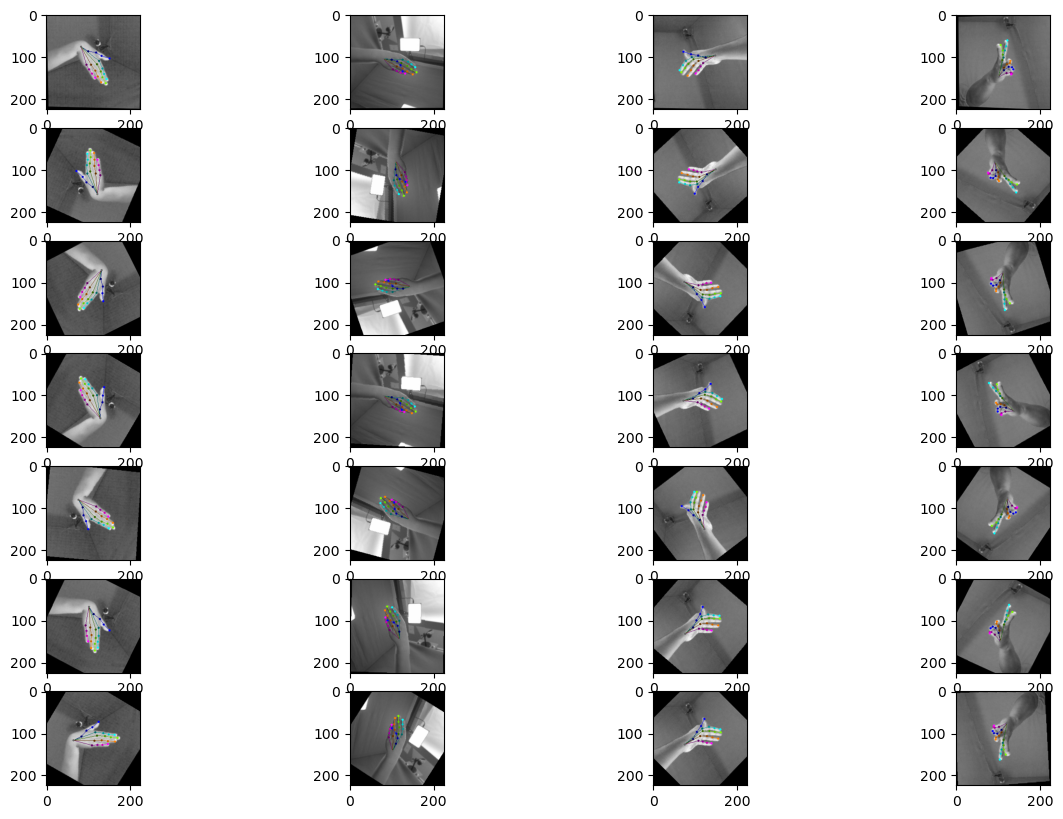

In [ ]:
batch_iter = iter(train_dl)
batch = next(batch_iter)

imgs = batch['image'] #return[img1, img2, img3]
kp = batch['keypoints'] #return[keypoint1, keypoint2, keypoint3]
# print(batch['image'])
pic_num = 4
fig, axes = plt.subplots(len(imgs), pic_num, figsize=(15, 10))
for i in range(len(imgs)):
    for j in range(pic_num):
        # 將圖像和關鍵點轉換為 NumPy 格式
        img_np = imgs[i][j].permute(1, 2, 0).numpy()
        kp_np = kp[i][j].numpy() * 224

        # 使用 draw_hand 函數繪製關鍵點
        img_with_hand = draw_hand(img_np, kp_np)

        # 顯示結果
        axes[i, j].imshow(img_with_hand)
        # axes[i, j].axis('off')

plt.show()


# Model

+ Model Specifications:
  + Input: **`[B, 3, 224, 224]`**
  + Output: **`[B, 21, 2]`** --> 21 for the num of the landmarks, 2 for the coordinates in (x, y) format
  + Layer: You can build up your own model architecture with no limitations.
  + Cost: The computational cost (FLOPs) may not over **`20 GFLOPs`**

In [ ]:
from torchvision import models

class HandPoseNet(nn.Module):
    def __init__(self):
        super(HandPoseNet, self).__init__()
        self.mobileNet1 = models.mobilenet_v3_small(pretrained=True)
        # self.mobileNet1.features[14].conv[1][0].stride = (1, 1)
        # self.mobileNet1.classifier = torch.nn.Identity()
        
        self.dw1 = nn.Sequential(
            nn.Conv2d(576, 64, kernel_size=1, stride=1, padding=0),
            nn.ReLU6(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, groups=64),
            nn.ReLU6(),
            nn.Conv2d(64, 128, kernel_size=1, stride=1, padding=0),
        )
        self.conv_1x1 = nn.Conv2d(576, 128, kernel_size=1, stride=1, padding=0)
        self.leakyRelu = nn.LeakyReLU()
        self.dw2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=1, stride=1, padding=0),
            nn.ReLU6(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, groups=64),
            nn.ReLU6(),
            nn.Conv2d(64, 128, kernel_size=1, stride=1, padding=0),
            nn.ReLU6(),
        )
        # input: 7x7, output: 14x14 --> kernel_size=4, stride=2, padding=1, 7 = (14 - 4 + 2*1) / 2 + 1
        self.transposed_conv1 = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU6(),
        )
        self.transposed_conv2 = nn.Sequential(
            nn.ConvTranspose2d(128, 3*21, kernel_size=4, stride=2, padding=1),
        )
        self.dw3 = nn.Sequential(
            nn.Conv2d(128+3*21, 128, kernel_size=1, stride=1, padding=0),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, groups=128),
            nn.ReLU6(),
            nn.Conv2d(128, 3*21, kernel_size=1, stride=1, padding=0),
        )
        self.fc1 = nn.Linear(3*21*14*14, 2*21)
        # self.fc1_2 = nn.Linear(256*7*7, 2*21)

    def forward(self, x):
        # x = self.mobileNet1(x) 
        x = self.mobileNet1.features(x) # [B, 576, 7, 7]
        y = self.dw1(x) # [B, 256, 7, 7]
        z = self.conv_1x1(x) # [B, 256, 7, 7]
        x = self.leakyRelu(y + z) # [B, 256, 7, 7]
        x = self.dw2(x) # [B, 256, 7, 7]
        y = self.transposed_conv1(x) # [B, 128, 14, 14]
        z = self.transposed_conv2(x) # [B, 3*21, 14, 14]
        z1, z2 = torch.split(z, [2*21, 21], dim=1)
        x = self.dw3(torch.cat([z1, y, z2], dim=1)) # [B, 3*21, 14, 14]
        x = torch.flatten(x, start_dim=1) # [B, 3*21*14*14]
        x = self.fc1(x) # [B, 2*21]
        x = x.view(-1, 21, 2)  # Reshape to [B, 21, 2]
        return x

Net = HandPoseNet()

# Testing Model Computational Cost

In [ ]:
# pseudo image
image = torch.rand(1, 3, 224, 224).cuda()

# define your model
model = Net.to(config["device"])

out = model(image)

# torchsummary report
summary(model, input_size=(3, 224, 224))
print(f'From input shape: {image.shape} to output shape: {out.shape}')

# thop report
macs, parm = profile(model, inputs=(image, ))
print(f'FLOPS: {macs * 2 / 1e9} G, Params: {parm / 1e6} M.')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14           [-1, 16,

# Criterion

In [ ]:
class CMSELoss(nn.Module):
  """
  Coordinate MSE loss
  input :
    y_pred = b, 21, 2   (coordinate of 21 keypoints)
    y_true = b, 21, 2   (keypoints, (y, x))
  """
  def __init__(self):
    super().__init__()
    self.loss = nn.MSELoss()

  def forward(self, y_pred, y_true):
    y_true = torch.flip(y_true, [2]) # flip (y, x) to (x, y)
    return self.loss(y_pred, y_true)

In [ ]:
criterion = CMSELoss()

# Optimizer and Scheduler (optional)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
# optimizer = torch.optim.Adadelta(model.parameters(), lr=1)

In [ ]:
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.002, steps_per_epoch=len(train_dl), epochs=config["n_epochs"])
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_dl), epochs=config["n_epochs"], div_factor=2, final_div_factor=5, pct_start=0.09)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = config["rot_num"] * (len(train_dl.dataset) / config["batch_size"]) * config["n_epochs"], eta_min = 0.00005)
print((len(train_dl.dataset) / config["batch_size"]) * config["n_epochs"])

150000.0


# Training
  + Record the **`loss / epoch`** learning curve
  + If using learning rate scheduler, record the **`lr / epoch`** curve

In [ ]:
# weight_path = '/home/va8800/ken_ai/model_weights.pth'
# weight_path = '/home/STuser19/MID/model_weights.pth'

# checkpoint = torch.load(weight_path)
# model.load_state_dict(checkpoint, strict=True)

In [ ]:
# initialize tracker for minimum validation loss
# valid_loss_min = np.Inf # set initial "min" to infinity
valid_loss_min = np.inf # set initial "min" to infinity

# initialize history for recording what we want to know
history = []

for epoch in range(config["n_epochs"]):
    # monitor training loss, validation loss and learning rate
    train_loss = 0.0
    valid_loss = 0.0
    lrs    = []
    result = {'train_loss': [], 'val_loss': [], 'lrs': []}

    # prepare model for training
    model.train()

    #######################
    # train the model #
    #######################
    for batch in tqdm(train_dl):
        for i in range(len(batch['image'])):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'][i].to(config['device']))
            # calculate the loss
            loss = criterion(output, batch['keypoints'][i].to(config['device']))
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            scheduler.step()

            # record learning rate
            lrs.append(optimizer.param_groups[0]['lr'])

            # update running training loss
            train_loss += loss.item()*batch['image'][i].size(0)

    ######################
    # validate the model #
    ######################
    model.eval()
    for batch in val_dl:
        # compute predicted outputs by passing inputs to the model
        output = model(batch['image'][0].to(config['device']))
        # calculate the loss
        loss = criterion(output, batch['keypoints'][0].to(config['device']))
        # update running validation loss
        valid_loss += loss.item()*batch['image'][0].size(0)

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss/(len(train_dl.dataset)*config["rot_num"])
    result['train_loss'] = train_loss
    valid_loss = valid_loss/len(val_dl.dataset)
    result['val_loss'] = valid_loss
    leaning_rate = lrs
    result['lrs'] = leaning_rate
    history.append(result)

    print('Epoch {:2d}: Learning Rate: {:.6f} Training Loss: {:.6f} Validation Loss:{:.6f}'.format(
        epoch+1,
        leaning_rate[-1],
        train_loss,
        valid_loss
        ))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print("Validation loss decreased({:.6f}-->{:.6f}). Saving model ..".format(
        valid_loss_min,
        valid_loss
        ))
        torch.save(model.state_dict(),"model.pt")
        valid_loss_min = valid_loss

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [06:54<00:00,  2.41it/s]


Epoch  1: Learning Rate: 0.000500 Training Loss: 0.002876 Validation Loss:0.001973
Validation loss decreased(inf-->0.001973). Saving model ..


100%|██████████| 1000/1000 [06:47<00:00,  2.46it/s]


Epoch  2: Learning Rate: 0.000500 Training Loss: 0.001493 Validation Loss:0.001425
Validation loss decreased(0.001973-->0.001425). Saving model ..


100%|██████████| 1000/1000 [06:55<00:00,  2.40it/s]


Epoch  3: Learning Rate: 0.000500 Training Loss: 0.001167 Validation Loss:0.001123
Validation loss decreased(0.001425-->0.001123). Saving model ..


100%|██████████| 1000/1000 [06:56<00:00,  2.40it/s]


Epoch  4: Learning Rate: 0.000499 Training Loss: 0.000990 Validation Loss:0.001209


100%|██████████| 1000/1000 [07:17<00:00,  2.28it/s]


Epoch  5: Learning Rate: 0.000499 Training Loss: 0.000878 Validation Loss:0.000952
Validation loss decreased(0.001123-->0.000952). Saving model ..


100%|██████████| 1000/1000 [07:01<00:00,  2.37it/s]


Epoch  6: Learning Rate: 0.000498 Training Loss: 0.000784 Validation Loss:0.000889
Validation loss decreased(0.000952-->0.000889). Saving model ..


100%|██████████| 1000/1000 [06:53<00:00,  2.42it/s]


Epoch  7: Learning Rate: 0.000498 Training Loss: 0.000708 Validation Loss:0.000830
Validation loss decreased(0.000889-->0.000830). Saving model ..


100%|██████████| 1000/1000 [07:17<00:00,  2.29it/s]


Epoch  8: Learning Rate: 0.000497 Training Loss: 0.000655 Validation Loss:0.000769
Validation loss decreased(0.000830-->0.000769). Saving model ..


100%|██████████| 1000/1000 [07:19<00:00,  2.28it/s]


Epoch  9: Learning Rate: 0.000496 Training Loss: 0.000615 Validation Loss:0.000827


100%|██████████| 1000/1000 [06:58<00:00,  2.39it/s]


Epoch 10: Learning Rate: 0.000495 Training Loss: 0.000568 Validation Loss:0.000786


100%|██████████| 1000/1000 [07:00<00:00,  2.38it/s]


Epoch 11: Learning Rate: 0.000494 Training Loss: 0.000536 Validation Loss:0.000777


100%|██████████| 1000/1000 [06:55<00:00,  2.41it/s]


Epoch 12: Learning Rate: 0.000493 Training Loss: 0.000509 Validation Loss:0.000756
Validation loss decreased(0.000769-->0.000756). Saving model ..


100%|██████████| 1000/1000 [08:02<00:00,  2.07it/s]


Epoch 13: Learning Rate: 0.000492 Training Loss: 0.000479 Validation Loss:0.000670
Validation loss decreased(0.000756-->0.000670). Saving model ..


100%|██████████| 1000/1000 [09:10<00:00,  1.82it/s]


Epoch 14: Learning Rate: 0.000490 Training Loss: 0.000461 Validation Loss:0.000675


100%|██████████| 1000/1000 [11:18<00:00,  1.47it/s]


Epoch 15: Learning Rate: 0.000489 Training Loss: 0.000431 Validation Loss:0.000618
Validation loss decreased(0.000670-->0.000618). Saving model ..


100%|██████████| 1000/1000 [11:18<00:00,  1.47it/s]


Epoch 16: Learning Rate: 0.000487 Training Loss: 0.000411 Validation Loss:0.000609
Validation loss decreased(0.000618-->0.000609). Saving model ..


100%|██████████| 1000/1000 [11:18<00:00,  1.47it/s]


Epoch 17: Learning Rate: 0.000486 Training Loss: 0.000392 Validation Loss:0.000626


100%|██████████| 1000/1000 [11:19<00:00,  1.47it/s]


Epoch 18: Learning Rate: 0.000484 Training Loss: 0.000377 Validation Loss:0.000592
Validation loss decreased(0.000609-->0.000592). Saving model ..


100%|██████████| 1000/1000 [11:19<00:00,  1.47it/s]


Epoch 19: Learning Rate: 0.000482 Training Loss: 0.000360 Validation Loss:0.000610


100%|██████████| 1000/1000 [10:15<00:00,  1.62it/s]


Epoch 20: Learning Rate: 0.000481 Training Loss: 0.000341 Validation Loss:0.000580
Validation loss decreased(0.000592-->0.000580). Saving model ..


100%|██████████| 1000/1000 [08:22<00:00,  1.99it/s]


Epoch 21: Learning Rate: 0.000479 Training Loss: 0.000332 Validation Loss:0.000573
Validation loss decreased(0.000580-->0.000573). Saving model ..


100%|██████████| 1000/1000 [07:18<00:00,  2.28it/s]


Epoch 22: Learning Rate: 0.000477 Training Loss: 0.000325 Validation Loss:0.000557
Validation loss decreased(0.000573-->0.000557). Saving model ..


100%|██████████| 1000/1000 [06:40<00:00,  2.50it/s]


Epoch 23: Learning Rate: 0.000474 Training Loss: 0.000312 Validation Loss:0.000527
Validation loss decreased(0.000557-->0.000527). Saving model ..


100%|██████████| 1000/1000 [06:36<00:00,  2.52it/s]


Epoch 24: Learning Rate: 0.000472 Training Loss: 0.000297 Validation Loss:0.000566


100%|██████████| 1000/1000 [06:37<00:00,  2.52it/s]


Epoch 25: Learning Rate: 0.000470 Training Loss: 0.000289 Validation Loss:0.000566


100%|██████████| 1000/1000 [06:30<00:00,  2.56it/s]


Epoch 26: Learning Rate: 0.000467 Training Loss: 0.000280 Validation Loss:0.000620


100%|██████████| 1000/1000 [06:30<00:00,  2.56it/s]


Epoch 27: Learning Rate: 0.000465 Training Loss: 0.000273 Validation Loss:0.000532


100%|██████████| 1000/1000 [06:38<00:00,  2.51it/s]


Epoch 28: Learning Rate: 0.000462 Training Loss: 0.000262 Validation Loss:0.000514
Validation loss decreased(0.000527-->0.000514). Saving model ..


100%|██████████| 1000/1000 [06:34<00:00,  2.53it/s]


Epoch 29: Learning Rate: 0.000460 Training Loss: 0.000255 Validation Loss:0.000562


100%|██████████| 1000/1000 [06:34<00:00,  2.54it/s]


Epoch 30: Learning Rate: 0.000457 Training Loss: 0.000246 Validation Loss:0.000534


100%|██████████| 1000/1000 [06:32<00:00,  2.55it/s]


Epoch 31: Learning Rate: 0.000454 Training Loss: 0.000241 Validation Loss:0.000613


100%|██████████| 1000/1000 [06:33<00:00,  2.54it/s]


Epoch 32: Learning Rate: 0.000451 Training Loss: 0.000234 Validation Loss:0.000518


100%|██████████| 1000/1000 [06:38<00:00,  2.51it/s]


Epoch 33: Learning Rate: 0.000448 Training Loss: 0.000231 Validation Loss:0.000486
Validation loss decreased(0.000514-->0.000486). Saving model ..


100%|██████████| 1000/1000 [06:36<00:00,  2.52it/s]


Epoch 34: Learning Rate: 0.000445 Training Loss: 0.000223 Validation Loss:0.000489


100%|██████████| 1000/1000 [06:35<00:00,  2.53it/s]


Epoch 35: Learning Rate: 0.000442 Training Loss: 0.000215 Validation Loss:0.000512


100%|██████████| 1000/1000 [06:38<00:00,  2.51it/s]


Epoch 36: Learning Rate: 0.000439 Training Loss: 0.000211 Validation Loss:0.000503


100%|██████████| 1000/1000 [06:37<00:00,  2.52it/s]


Epoch 37: Learning Rate: 0.000436 Training Loss: 0.000207 Validation Loss:0.000494


100%|██████████| 1000/1000 [06:34<00:00,  2.53it/s]


Epoch 38: Learning Rate: 0.000432 Training Loss: 0.000200 Validation Loss:0.000483
Validation loss decreased(0.000486-->0.000483). Saving model ..


100%|██████████| 1000/1000 [06:36<00:00,  2.52it/s]


Epoch 39: Learning Rate: 0.000429 Training Loss: 0.000199 Validation Loss:0.000530


100%|██████████| 1000/1000 [06:36<00:00,  2.52it/s]


Epoch 40: Learning Rate: 0.000426 Training Loss: 0.000192 Validation Loss:0.000516


100%|██████████| 1000/1000 [06:38<00:00,  2.51it/s]


Epoch 41: Learning Rate: 0.000422 Training Loss: 0.000188 Validation Loss:0.000491


100%|██████████| 1000/1000 [06:34<00:00,  2.54it/s]


Epoch 42: Learning Rate: 0.000418 Training Loss: 0.000185 Validation Loss:0.000494


100%|██████████| 1000/1000 [06:34<00:00,  2.54it/s]


Epoch 43: Learning Rate: 0.000415 Training Loss: 0.000180 Validation Loss:0.000492


100%|██████████| 1000/1000 [06:35<00:00,  2.53it/s]


Epoch 44: Learning Rate: 0.000411 Training Loss: 0.000177 Validation Loss:0.000513


100%|██████████| 1000/1000 [06:38<00:00,  2.51it/s]


Epoch 45: Learning Rate: 0.000407 Training Loss: 0.000172 Validation Loss:0.000487


100%|██████████| 1000/1000 [06:33<00:00,  2.54it/s]


Epoch 46: Learning Rate: 0.000403 Training Loss: 0.000170 Validation Loss:0.000470
Validation loss decreased(0.000483-->0.000470). Saving model ..


100%|██████████| 1000/1000 [07:09<00:00,  2.33it/s]


Epoch 47: Learning Rate: 0.000400 Training Loss: 0.000167 Validation Loss:0.000487


100%|██████████| 1000/1000 [07:01<00:00,  2.37it/s]


Epoch 48: Learning Rate: 0.000396 Training Loss: 0.000162 Validation Loss:0.000458
Validation loss decreased(0.000470-->0.000458). Saving model ..


100%|██████████| 1000/1000 [07:13<00:00,  2.31it/s]


Epoch 49: Learning Rate: 0.000392 Training Loss: 0.000160 Validation Loss:0.000452
Validation loss decreased(0.000458-->0.000452). Saving model ..


100%|██████████| 1000/1000 [07:13<00:00,  2.31it/s]


Epoch 50: Learning Rate: 0.000387 Training Loss: 0.000157 Validation Loss:0.000457


100%|██████████| 1000/1000 [07:01<00:00,  2.37it/s]


Epoch 51: Learning Rate: 0.000383 Training Loss: 0.000156 Validation Loss:0.000461


100%|██████████| 1000/1000 [07:08<00:00,  2.33it/s]


Epoch 52: Learning Rate: 0.000379 Training Loss: 0.000151 Validation Loss:0.000478


100%|██████████| 1000/1000 [07:07<00:00,  2.34it/s]


Epoch 53: Learning Rate: 0.000375 Training Loss: 0.000149 Validation Loss:0.000456


100%|██████████| 1000/1000 [07:10<00:00,  2.32it/s]


Epoch 54: Learning Rate: 0.000371 Training Loss: 0.000148 Validation Loss:0.000454


100%|██████████| 1000/1000 [07:10<00:00,  2.32it/s]


Epoch 55: Learning Rate: 0.000367 Training Loss: 0.000143 Validation Loss:0.000471


100%|██████████| 1000/1000 [07:14<00:00,  2.30it/s]


Epoch 56: Learning Rate: 0.000362 Training Loss: 0.000141 Validation Loss:0.000457


100%|██████████| 1000/1000 [07:09<00:00,  2.33it/s]


Epoch 57: Learning Rate: 0.000358 Training Loss: 0.000139 Validation Loss:0.000460


100%|██████████| 1000/1000 [07:05<00:00,  2.35it/s]


Epoch 58: Learning Rate: 0.000353 Training Loss: 0.000136 Validation Loss:0.000451
Validation loss decreased(0.000452-->0.000451). Saving model ..


100%|██████████| 1000/1000 [07:03<00:00,  2.36it/s]


Epoch 59: Learning Rate: 0.000349 Training Loss: 0.000134 Validation Loss:0.000456


100%|██████████| 1000/1000 [07:05<00:00,  2.35it/s]


Epoch 60: Learning Rate: 0.000345 Training Loss: 0.000133 Validation Loss:0.000514


100%|██████████| 1000/1000 [06:57<00:00,  2.40it/s]


Epoch 61: Learning Rate: 0.000340 Training Loss: 0.000130 Validation Loss:0.000450
Validation loss decreased(0.000451-->0.000450). Saving model ..


100%|██████████| 1000/1000 [07:09<00:00,  2.33it/s]


Epoch 62: Learning Rate: 0.000336 Training Loss: 0.000129 Validation Loss:0.000454


100%|██████████| 1000/1000 [07:05<00:00,  2.35it/s]


Epoch 63: Learning Rate: 0.000331 Training Loss: 0.000126 Validation Loss:0.000458


100%|██████████| 1000/1000 [07:18<00:00,  2.28it/s]


Epoch 64: Learning Rate: 0.000326 Training Loss: 0.000125 Validation Loss:0.000449
Validation loss decreased(0.000450-->0.000449). Saving model ..


100%|██████████| 1000/1000 [07:27<00:00,  2.24it/s]


Epoch 65: Learning Rate: 0.000322 Training Loss: 0.000122 Validation Loss:0.000465


100%|██████████| 1000/1000 [07:23<00:00,  2.25it/s]


Epoch 66: Learning Rate: 0.000317 Training Loss: 0.000121 Validation Loss:0.000452


100%|██████████| 1000/1000 [07:05<00:00,  2.35it/s]


Epoch 67: Learning Rate: 0.000313 Training Loss: 0.000119 Validation Loss:0.000465


100%|██████████| 1000/1000 [07:33<00:00,  2.21it/s]


Epoch 68: Learning Rate: 0.000308 Training Loss: 0.000118 Validation Loss:0.000448
Validation loss decreased(0.000449-->0.000448). Saving model ..


100%|██████████| 1000/1000 [07:17<00:00,  2.29it/s]


Epoch 69: Learning Rate: 0.000303 Training Loss: 0.000116 Validation Loss:0.000447
Validation loss decreased(0.000448-->0.000447). Saving model ..


100%|██████████| 1000/1000 [07:20<00:00,  2.27it/s]


Epoch 70: Learning Rate: 0.000299 Training Loss: 0.000115 Validation Loss:0.000443
Validation loss decreased(0.000447-->0.000443). Saving model ..


100%|██████████| 1000/1000 [07:22<00:00,  2.26it/s]


Epoch 71: Learning Rate: 0.000294 Training Loss: 0.000113 Validation Loss:0.000442
Validation loss decreased(0.000443-->0.000442). Saving model ..


100%|██████████| 1000/1000 [07:26<00:00,  2.24it/s]


Epoch 72: Learning Rate: 0.000289 Training Loss: 0.000111 Validation Loss:0.000433
Validation loss decreased(0.000442-->0.000433). Saving model ..


100%|██████████| 1000/1000 [07:18<00:00,  2.28it/s]


Epoch 73: Learning Rate: 0.000284 Training Loss: 0.000110 Validation Loss:0.000433
Validation loss decreased(0.000433-->0.000433). Saving model ..


100%|██████████| 1000/1000 [07:23<00:00,  2.26it/s]


Epoch 74: Learning Rate: 0.000280 Training Loss: 0.000108 Validation Loss:0.000433


100%|██████████| 1000/1000 [07:02<00:00,  2.37it/s]


Epoch 75: Learning Rate: 0.000275 Training Loss: 0.000108 Validation Loss:0.000444


100%|██████████| 1000/1000 [07:01<00:00,  2.37it/s]


Epoch 76: Learning Rate: 0.000270 Training Loss: 0.000105 Validation Loss:0.000434


100%|██████████| 1000/1000 [07:11<00:00,  2.32it/s]


Epoch 77: Learning Rate: 0.000266 Training Loss: 0.000104 Validation Loss:0.000427
Validation loss decreased(0.000433-->0.000427). Saving model ..


100%|██████████| 1000/1000 [07:08<00:00,  2.33it/s]


Epoch 78: Learning Rate: 0.000261 Training Loss: 0.000103 Validation Loss:0.000427


100%|██████████| 1000/1000 [07:07<00:00,  2.34it/s]


Epoch 79: Learning Rate: 0.000256 Training Loss: 0.000102 Validation Loss:0.000430


100%|██████████| 1000/1000 [07:05<00:00,  2.35it/s]


Epoch 80: Learning Rate: 0.000251 Training Loss: 0.000100 Validation Loss:0.000436


100%|██████████| 1000/1000 [07:09<00:00,  2.33it/s]


Epoch 81: Learning Rate: 0.000247 Training Loss: 0.000099 Validation Loss:0.000427
Validation loss decreased(0.000427-->0.000427). Saving model ..


100%|██████████| 1000/1000 [07:00<00:00,  2.38it/s]


Epoch 82: Learning Rate: 0.000242 Training Loss: 0.000099 Validation Loss:0.000430


100%|██████████| 1000/1000 [07:03<00:00,  2.36it/s]


Epoch 83: Learning Rate: 0.000237 Training Loss: 0.000097 Validation Loss:0.000444


100%|██████████| 1000/1000 [06:59<00:00,  2.38it/s]


Epoch 84: Learning Rate: 0.000233 Training Loss: 0.000096 Validation Loss:0.000415
Validation loss decreased(0.000427-->0.000415). Saving model ..


100%|██████████| 1000/1000 [07:04<00:00,  2.35it/s]


Epoch 85: Learning Rate: 0.000228 Training Loss: 0.000094 Validation Loss:0.000419


100%|██████████| 1000/1000 [07:15<00:00,  2.30it/s]


Epoch 86: Learning Rate: 0.000224 Training Loss: 0.000093 Validation Loss:0.000412
Validation loss decreased(0.000415-->0.000412). Saving model ..


100%|██████████| 1000/1000 [07:05<00:00,  2.35it/s]


Epoch 87: Learning Rate: 0.000219 Training Loss: 0.000092 Validation Loss:0.000418


100%|██████████| 1000/1000 [07:02<00:00,  2.37it/s]


Epoch 88: Learning Rate: 0.000214 Training Loss: 0.000091 Validation Loss:0.000421


100%|██████████| 1000/1000 [07:07<00:00,  2.34it/s]


Epoch 89: Learning Rate: 0.000210 Training Loss: 0.000090 Validation Loss:0.000425


100%|██████████| 1000/1000 [07:04<00:00,  2.35it/s]


Epoch 90: Learning Rate: 0.000205 Training Loss: 0.000089 Validation Loss:0.000414


100%|██████████| 1000/1000 [07:07<00:00,  2.34it/s]


Epoch 91: Learning Rate: 0.000201 Training Loss: 0.000088 Validation Loss:0.000414


100%|██████████| 1000/1000 [07:12<00:00,  2.31it/s]


Epoch 92: Learning Rate: 0.000197 Training Loss: 0.000087 Validation Loss:0.000427


100%|██████████| 1000/1000 [07:06<00:00,  2.35it/s]


Epoch 93: Learning Rate: 0.000192 Training Loss: 0.000087 Validation Loss:0.000423


100%|██████████| 1000/1000 [07:29<00:00,  2.22it/s]


Epoch 94: Learning Rate: 0.000188 Training Loss: 0.000086 Validation Loss:0.000410
Validation loss decreased(0.000412-->0.000410). Saving model ..


100%|██████████| 1000/1000 [07:13<00:00,  2.31it/s]


Epoch 95: Learning Rate: 0.000183 Training Loss: 0.000084 Validation Loss:0.000422


100%|██████████| 1000/1000 [07:07<00:00,  2.34it/s]


Epoch 96: Learning Rate: 0.000179 Training Loss: 0.000084 Validation Loss:0.000414


100%|██████████| 1000/1000 [07:15<00:00,  2.30it/s]


Epoch 97: Learning Rate: 0.000175 Training Loss: 0.000083 Validation Loss:0.000416


100%|██████████| 1000/1000 [07:20<00:00,  2.27it/s]


Epoch 98: Learning Rate: 0.000171 Training Loss: 0.000082 Validation Loss:0.000419


100%|██████████| 1000/1000 [07:17<00:00,  2.28it/s]


Epoch 99: Learning Rate: 0.000167 Training Loss: 0.000081 Validation Loss:0.000420


100%|██████████| 1000/1000 [07:07<00:00,  2.34it/s]


Epoch 100: Learning Rate: 0.000162 Training Loss: 0.000081 Validation Loss:0.000415


100%|██████████| 1000/1000 [07:15<00:00,  2.30it/s]


Epoch 101: Learning Rate: 0.000158 Training Loss: 0.000080 Validation Loss:0.000408
Validation loss decreased(0.000410-->0.000408). Saving model ..


100%|██████████| 1000/1000 [07:12<00:00,  2.31it/s]


Epoch 102: Learning Rate: 0.000154 Training Loss: 0.000079 Validation Loss:0.000417


100%|██████████| 1000/1000 [07:04<00:00,  2.35it/s]


Epoch 103: Learning Rate: 0.000150 Training Loss: 0.000078 Validation Loss:0.000411


100%|██████████| 1000/1000 [07:20<00:00,  2.27it/s]


Epoch 104: Learning Rate: 0.000147 Training Loss: 0.000077 Validation Loss:0.000403
Validation loss decreased(0.000408-->0.000403). Saving model ..


100%|██████████| 1000/1000 [07:28<00:00,  2.23it/s]


Epoch 105: Learning Rate: 0.000143 Training Loss: 0.000077 Validation Loss:0.000409


100%|██████████| 1000/1000 [07:28<00:00,  2.23it/s]


Epoch 106: Learning Rate: 0.000139 Training Loss: 0.000077 Validation Loss:0.000400
Validation loss decreased(0.000403-->0.000400). Saving model ..


100%|██████████| 1000/1000 [07:22<00:00,  2.26it/s]


Epoch 107: Learning Rate: 0.000135 Training Loss: 0.000076 Validation Loss:0.000413


100%|██████████| 1000/1000 [07:31<00:00,  2.21it/s]


Epoch 108: Learning Rate: 0.000132 Training Loss: 0.000075 Validation Loss:0.000409


100%|██████████| 1000/1000 [07:35<00:00,  2.19it/s]


Epoch 109: Learning Rate: 0.000128 Training Loss: 0.000074 Validation Loss:0.000415


100%|██████████| 1000/1000 [07:19<00:00,  2.27it/s]


Epoch 110: Learning Rate: 0.000124 Training Loss: 0.000074 Validation Loss:0.000401


100%|██████████| 1000/1000 [07:11<00:00,  2.31it/s]


Epoch 111: Learning Rate: 0.000121 Training Loss: 0.000073 Validation Loss:0.000412


100%|██████████| 1000/1000 [07:24<00:00,  2.25it/s]


Epoch 112: Learning Rate: 0.000118 Training Loss: 0.000072 Validation Loss:0.000416


100%|██████████| 1000/1000 [07:27<00:00,  2.23it/s]


Epoch 113: Learning Rate: 0.000114 Training Loss: 0.000072 Validation Loss:0.000404


100%|██████████| 1000/1000 [07:13<00:00,  2.31it/s]


Epoch 114: Learning Rate: 0.000111 Training Loss: 0.000072 Validation Loss:0.000412


100%|██████████| 1000/1000 [07:23<00:00,  2.26it/s]


Epoch 115: Learning Rate: 0.000108 Training Loss: 0.000071 Validation Loss:0.000409


100%|██████████| 1000/1000 [07:19<00:00,  2.28it/s]


Epoch 116: Learning Rate: 0.000105 Training Loss: 0.000070 Validation Loss:0.000406


100%|██████████| 1000/1000 [07:22<00:00,  2.26it/s]


Epoch 117: Learning Rate: 0.000102 Training Loss: 0.000070 Validation Loss:0.000413


100%|██████████| 1000/1000 [07:13<00:00,  2.31it/s]


Epoch 118: Learning Rate: 0.000099 Training Loss: 0.000069 Validation Loss:0.000408


100%|██████████| 1000/1000 [07:16<00:00,  2.29it/s]


Epoch 119: Learning Rate: 0.000096 Training Loss: 0.000069 Validation Loss:0.000410


100%|██████████| 1000/1000 [07:26<00:00,  2.24it/s]


Epoch 120: Learning Rate: 0.000093 Training Loss: 0.000068 Validation Loss:0.000411


100%|██████████| 1000/1000 [07:06<00:00,  2.35it/s]


Epoch 121: Learning Rate: 0.000090 Training Loss: 0.000068 Validation Loss:0.000404


100%|██████████| 1000/1000 [07:09<00:00,  2.33it/s]


Epoch 122: Learning Rate: 0.000088 Training Loss: 0.000067 Validation Loss:0.000401


100%|██████████| 1000/1000 [07:05<00:00,  2.35it/s]


Epoch 123: Learning Rate: 0.000085 Training Loss: 0.000067 Validation Loss:0.000406


100%|██████████| 1000/1000 [07:07<00:00,  2.34it/s]


Epoch 124: Learning Rate: 0.000083 Training Loss: 0.000067 Validation Loss:0.000410


100%|██████████| 1000/1000 [07:08<00:00,  2.33it/s]


Epoch 125: Learning Rate: 0.000080 Training Loss: 0.000066 Validation Loss:0.000399
Validation loss decreased(0.000400-->0.000399). Saving model ..


100%|██████████| 1000/1000 [07:15<00:00,  2.30it/s]


Epoch 126: Learning Rate: 0.000078 Training Loss: 0.000066 Validation Loss:0.000407


100%|██████████| 1000/1000 [07:05<00:00,  2.35it/s]


Epoch 127: Learning Rate: 0.000076 Training Loss: 0.000065 Validation Loss:0.000401


100%|██████████| 1000/1000 [07:07<00:00,  2.34it/s]


Epoch 128: Learning Rate: 0.000073 Training Loss: 0.000065 Validation Loss:0.000410


100%|██████████| 1000/1000 [07:23<00:00,  2.25it/s]


Epoch 129: Learning Rate: 0.000071 Training Loss: 0.000065 Validation Loss:0.000410


100%|██████████| 1000/1000 [07:28<00:00,  2.23it/s]


Epoch 130: Learning Rate: 0.000069 Training Loss: 0.000065 Validation Loss:0.000400


100%|██████████| 1000/1000 [09:52<00:00,  1.69it/s]


Epoch 131: Learning Rate: 0.000068 Training Loss: 0.000064 Validation Loss:0.000407


100%|██████████| 1000/1000 [09:47<00:00,  1.70it/s]


Epoch 132: Learning Rate: 0.000066 Training Loss: 0.000064 Validation Loss:0.000409


100%|██████████| 1000/1000 [08:24<00:00,  1.98it/s]


Epoch 133: Learning Rate: 0.000064 Training Loss: 0.000063 Validation Loss:0.000405


100%|██████████| 1000/1000 [09:44<00:00,  1.71it/s]


Epoch 134: Learning Rate: 0.000063 Training Loss: 0.000063 Validation Loss:0.000405


100%|██████████| 1000/1000 [09:48<00:00,  1.70it/s]


Epoch 135: Learning Rate: 0.000061 Training Loss: 0.000063 Validation Loss:0.000408


100%|██████████| 1000/1000 [09:15<00:00,  1.80it/s]


Epoch 136: Learning Rate: 0.000060 Training Loss: 0.000063 Validation Loss:0.000403


100%|██████████| 1000/1000 [09:10<00:00,  1.82it/s]


Epoch 137: Learning Rate: 0.000058 Training Loss: 0.000062 Validation Loss:0.000403


100%|██████████| 1000/1000 [08:30<00:00,  1.96it/s]


Epoch 138: Learning Rate: 0.000057 Training Loss: 0.000062 Validation Loss:0.000397
Validation loss decreased(0.000399-->0.000397). Saving model ..


100%|██████████| 1000/1000 [09:41<00:00,  1.72it/s]


Epoch 139: Learning Rate: 0.000056 Training Loss: 0.000062 Validation Loss:0.000403


100%|██████████| 1000/1000 [09:42<00:00,  1.72it/s]


Epoch 140: Learning Rate: 0.000055 Training Loss: 0.000062 Validation Loss:0.000403


100%|██████████| 1000/1000 [09:13<00:00,  1.81it/s]


Epoch 141: Learning Rate: 0.000054 Training Loss: 0.000062 Validation Loss:0.000404


100%|██████████| 1000/1000 [09:36<00:00,  1.73it/s]


Epoch 142: Learning Rate: 0.000053 Training Loss: 0.000061 Validation Loss:0.000404


100%|██████████| 1000/1000 [09:25<00:00,  1.77it/s]


Epoch 143: Learning Rate: 0.000052 Training Loss: 0.000061 Validation Loss:0.000401


100%|██████████| 1000/1000 [07:43<00:00,  2.16it/s]


Epoch 144: Learning Rate: 0.000052 Training Loss: 0.000061 Validation Loss:0.000407


100%|██████████| 1000/1000 [07:02<00:00,  2.37it/s]


Epoch 145: Learning Rate: 0.000051 Training Loss: 0.000061 Validation Loss:0.000409


100%|██████████| 1000/1000 [07:03<00:00,  2.36it/s]


Epoch 146: Learning Rate: 0.000051 Training Loss: 0.000061 Validation Loss:0.000408


100%|██████████| 1000/1000 [08:55<00:00,  1.87it/s]


Epoch 147: Learning Rate: 0.000050 Training Loss: 0.000061 Validation Loss:0.000403


100%|██████████| 1000/1000 [09:33<00:00,  1.74it/s]


Epoch 148: Learning Rate: 0.000050 Training Loss: 0.000060 Validation Loss:0.000404


100%|██████████| 1000/1000 [09:13<00:00,  1.81it/s]


Epoch 149: Learning Rate: 0.000050 Training Loss: 0.000061 Validation Loss:0.000402


100%|██████████| 1000/1000 [07:08<00:00,  2.33it/s]


Epoch 150: Learning Rate: 0.000050 Training Loss: 0.000060 Validation Loss:0.000402


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# torch.save(model.state_dict(), '/home/va8800/ken_ai/v3_2/model_weights.pth')
torch.save(model.state_dict(), '/home/STuser19/MID/v3/model_weights.pth')
print("Save model weight successfully.")

Save model weight successfully.


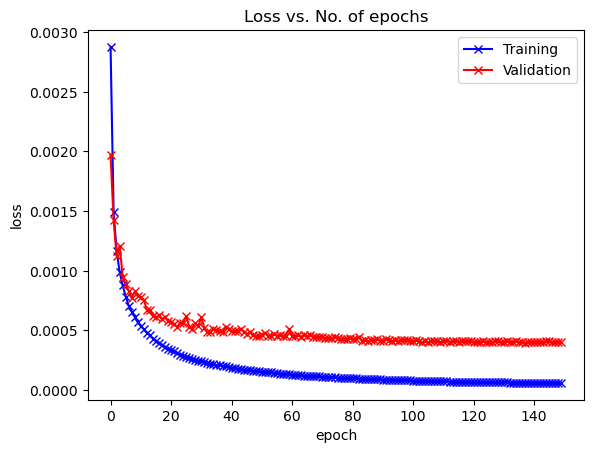

In [ ]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs. No. of epochs');

plot_losses(history)

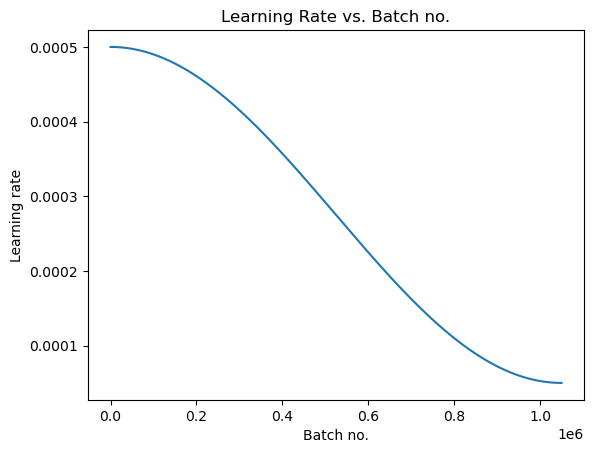

In [ ]:
def plot_lrs(history):
  lrs = np.concatenate([x.get('lrs', []) for x in history])
  plt.plot(lrs)
  plt.xlabel('Batch no.')
  plt.ylabel('Learning rate')
  plt.title('Learning Rate vs. Batch no.');

plot_lrs(history)

# Load your model

In [ ]:
# weight_path = '/home/va8800/ken_ai/v3_2/model_weights.pth'
weight_path = '/home/STuser19/MID/v3/model_weights.pth'

checkpoint = torch.load(weight_path)
model.eval()
model.load_state_dict(checkpoint, strict=True)

<All keys matched successfully>

In [ ]:
print(model)

HandPoseNet(
  (mobileNet1): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2): C

# Testing part (**do not modify!!**)

In [ ]:
class Testing_dataset(Dataset):
  def __init__(self, config):
    self.image_names = natsorted(glob(os.path.join(config['data_dir'], 'testing/rgb', '*.jpg')))

  def __len__(self):
    return len(self.image_names)

  def __getitem__(self, idx):
    # input
    image_name = self.image_names[idx]
    image = cv2.imread(image_name)
    image = torch.from_numpy(image.transpose(2, 0 ,1))
    image = image / 255

    return {
      'image_name': image_name,
      'image': image,
    }

In [ ]:
test_ds = Testing_dataset(config)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False, drop_last=False, num_workers=0)

In [ ]:
with open('./FreiHAND_pub_v2/golden_out.json', 'r') as f:
  golden_out = json.load(f)

In [ ]:
def evaluate(dataloader, model, golden_out):
  print(f'Total {len(dataloader)} iterations to be tested.')

  with torch.no_grad():
    result = {}
    loss = []
    pixeldiff = []
    for i, data in tqdm(enumerate(dataloader)):
      image_name = data['image_name'][0][-22:]
      # get golden ans and inputs
      golden_ans = torch.from_numpy(np.array(golden_out[image_name])).float().cuda()
      inputs = data['image'].cuda()

      # get predicted output
      outputs = model(inputs)

      # get loss
      l = criterion(outputs, golden_ans).cpu().numpy()
      loss.append(l)
      pixeldiff.append(np.sqrt(l) * 223)

      pred = outputs.cpu().detach().numpy().tolist()
      result.update({image_name: pred})

  print('\nTesting successfully!')
  return result, loss, pixeldiff

In [ ]:
result, loss, pixeldiff = evaluate(test_dl, model, golden_out)

with open("result.json", "w") as outfile:
  json.dump(result, outfile)

Total 1000 iterations to be tested.


1000it [00:10, 95.72it/s]


Testing successfully!


In [ ]:
with open('ID_result.csv', 'w') as f:
  f.write('Id,Loss\n')
  for i, data in enumerate(pixeldiff):
    f.write(str(i)+','+str(data)+'\n')

In [ ]:
import shutil
shutil.move('ID_result.csv', '/home/STuser19/MID/v3/ID_result.csv')
# shutil.move('ID_result.csv', '/home/va8800/ken_ai/v3_2/ID_result.csv')

'/home/STuser19/MID/v3/ID_result.csv'

In [ ]:
print(f'FLOPS: {macs * 2 / 1e9} G, Params: {parm / 1e6} M., avg pixeldiff: {np.mean(pixeldiff)}, avg loss: {np.mean(loss)}')
score = (macs * 2 / 1e9) * (parm / 1e6) * math.exp(np.mean(pixeldiff))
print("ranking score: ", "{:,}".format(score))

FLOPS: 0.302601376 G, Params: 2.007968 M., avg pixeldiff: 6.152803876982536, avg loss: 0.00122355786152184
ranking score:  285.59885234255654
